<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table id="top" class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./04_clustering.ipynb" title="Clustering">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">05</td>
    <td style="text-align:right; width:33%;">
      <a href="./06_predicting_sleep.ipynb" title="Predicting Sleep">Next &gt;</a>
    </td>
  </tr>
</table>

# Predicting Mental State
---

Import libraries:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib


---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [4]:
# List numeric columns
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "sleep_hours",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "mood_level",
    "anxiety_level"
]

# List categorical columns
categorical_features = ["gender", "platform"]

# List all features
features = numeric_features + categorical_features

# List target variable
target = "mental_state"

# Select features and target variable
data = df[features + [target]].copy()

---
## Train/Test split the data

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42, stratify=data[target]
)

---
## Build the pipeline

In [ ]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

---
## Add GridSearchCV

Define parameters grid:

In [ ]:
# Define hyperparameter grid for Random Forest
param_grid = {
    "model__n_estimators": [100, 300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

Run GridSearch:

In [9]:
# Set up the grid search
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


---
## Evaluate the best model

In [ ]:
# Get the best model from the grid search
best_model = grid.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

Metrics:

In [11]:
# Print best parameters
print("Best params:", grid.best_params_)

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print classification report
print(classification_report(y_test, y_pred))

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Accuracy: 1.0
              precision    recall  f1-score   support

     At Risk       1.00      1.00      1.00        12
     Healthy       1.00      1.00      1.00        68
    Stressed       1.00      1.00      1.00       920

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



The model has an accuracy of 1.0 which means that it correctly predicted all the test data correctly. This makes it more likely that the data set is synthetic which the EDA also pointed to.

Confusion matrix:

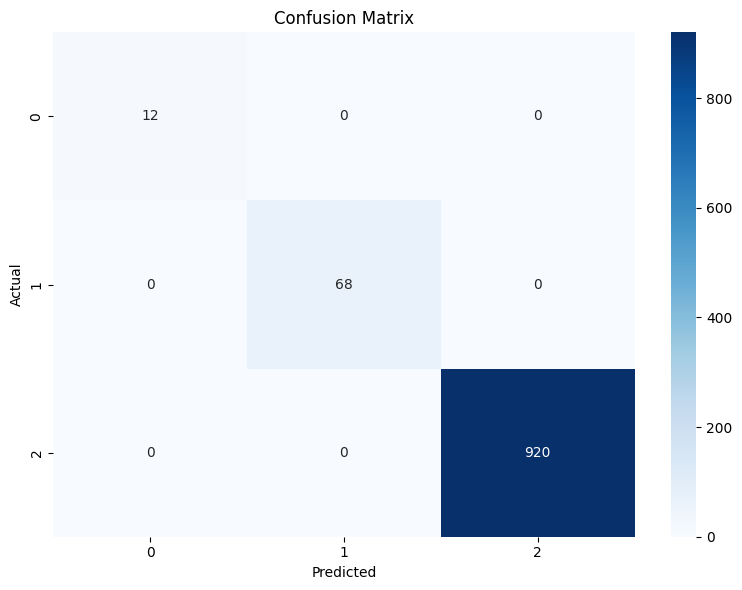

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show and save the plot
plt.tight_layout()
plt.savefig('../charts/predicting_mental_state_random_forest_confusion_matrix.png')
plt.show()

View the exported png [here](../charts/predicting_mental_state_random_forest_confusion_matrix.png)

Check the most important featues:

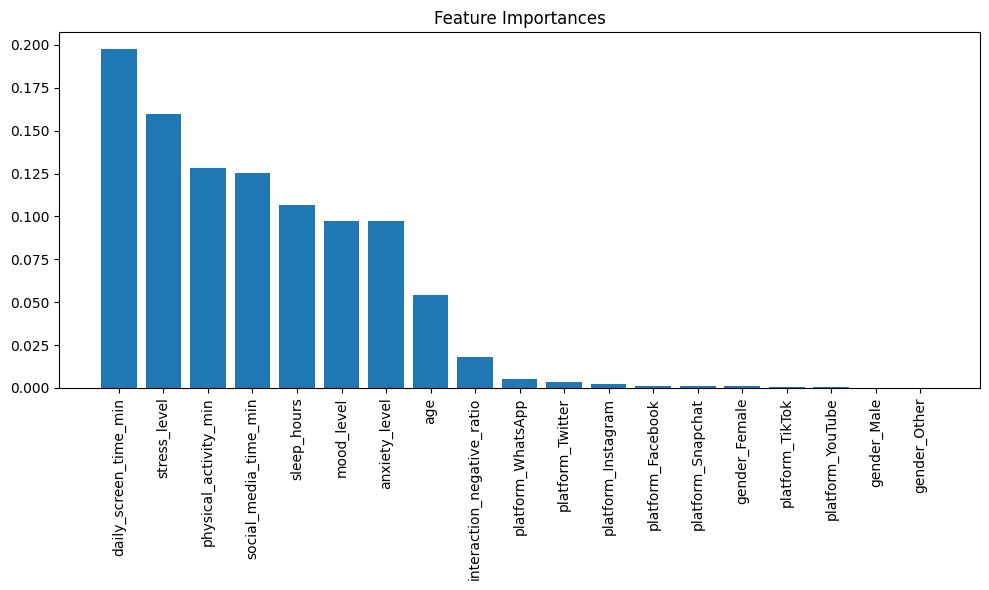

In [22]:

# Get numeric feature names
feature_names_num = numeric_features
# Get categorical feature names after one-hot encoding
feature_names_cat = best_model.named_steps["prep"].transformers_[1][1].get_feature_names_out(categorical_features)
# Combine numeric and categorical feature names
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Get feature importances from the best model
importances = best_model.named_steps["model"].feature_importances_
# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# set up the matplotlib figure and add title
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")

# Create bar plot
plt.bar(range(len(importances)), importances[indices], tick_label=all_feature_names[indices])

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show and save the plot
plt.savefig('../charts/predicting_mental_state_random_forest_feature_importances.png')
plt.tight_layout()
plt.show()

View the exported png [here](../charts/predicting_mental_state_random_forest_feature_importances.png)

### Summary

The feature importances make it pretty clear what the model is using to predict mental state. Screen time comes out on top, followed closely by stress, mood, anxiety, and other lifestyle factors like sleep and physical activity. These all make intuitive sense given how strongly they were linked to mental-state patterns earlier in the analysis.

What’s equally interesting is what doesn’t matter much: platform choice and gender barely influence the predictions at all. So while those features show some patterns in the EDA, they simply don’t help the model decide someone’s mental state. In short, the model is mostly looking at how much people use their devices and how they’re feeling, rather than who they are or which platform they prefer.

---
## Save the model

In [24]:
# Save the best model to a file
joblib.dump(best_model, '../models/predicting_mental_state_random_forest_model.pkl')

['../models/predicting_mental_state_random_forest_model.pkl']

---
## Run the model on unseen data

I am going to use the persona data created on the cluster notebook to make test predictions.

In [30]:
# laod the persona data
cluster_profiles = pd.read_parquet("../data/cluster_profiles.parquet")

# Prepare input data for prediction
persona_input = cluster_profiles.drop(columns=["mental_state"])

# Make predictions for each persona
preds = best_model.predict(persona_input)

# Combine predictions with cluster profiles
results = cluster_profiles.copy()
results["model_prediction"] = preds

# Display the results
results

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state,model_prediction
cluster,,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed,Stressed
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed,Stressed
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed,Stressed
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed,Stressed
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy,Healthy
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed,Stressed
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed,Stressed


--- 
## Conclusion

The mental state prediction model performed exceptionally well, achieving perfect accuracy on the test set.

The features most strongly associated with mental state, screen time, sleep, activity levels, stress, mood, and anxiety are so tightly linked that the model has very little ambiguity to resolve.

When I tested the model using the cluster personas from the clustering notebook, the predictions matched the expected mental state labels perfectly. This consistency across both real test data and synthetic personas shows that the model is internally coherent and captures the same patterns I observed in the EDA and clustering steps.

In short, the model behaves exactly as we would expect based on the structure of the dataset and reinforces the idea that emotional and behavioural factors drive mental state classification far more than demographics or platform choice.

---
<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./04_clustering.ipynb" title="Clustering">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">05</td>
    <td style="text-align:right; width:33%;">
      <a href="./06_predicting_sleep.ipynb" title="Predicting Sleep">Next &gt;</a>
    </td>
  </tr>
</table>
<p style="text-align:center;">
  <a href="#top">⬆ Back to top</a>
</p>